In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score , precision_score,recall_score
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
import numpy as np
import shap
import xgboost as xgb

In [33]:
data1  = pd.read_csv("Prepared_data.csv")
data2 = pd.read_csv("Prepared_data2.csv")

In [34]:
data1.head()

,Unnamed: 0,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,rp,date_renewal_months,date_end_months
0,0,4666,7,5,5.490346,0.000000,4.001128,4.423595,4.001128,0.0,2.556652,0.095919,0.088347,58.995952,0,2.920541,-41.76,-41.76,1,3.238889,3,2,18.402044,0,1460,11.0,11.0
1,1,2361,0,3,4.327104,4.739944,0.000000,3.085953,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.000000,25.44,25.44,2,2.832503,3,3,43.648000,1,1096,6.0,6.0
2,2,13250,0,4,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.145711,0.000000,44.311378,0,0.000000,16.38,16.38,1,1.298635,6,1,13.800000,0,2566,8.0,8.0
3,3,7430,0,3,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.165794,0.087899,44.311378,0,0.000000,28.60,28.60,1,0.880814,6,1,13.856000,0,2192,4.0,4.0
4,4,11748,0,5,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.146694,0.000000,44.311378,0,0.000000,30.22,30.22,1,1.422590,6,1,13.200000,0,2192,3.0,3.0


In [35]:
data2.head()

,Unnamed: 0,id,Unnamed: 0.1,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,0,0,72168.5,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
1,1,1,157114.5,0.146427,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000
2,2,2,168215.5,0.181559,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000
3,3,3,51909.5,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003
4,4,4,24565.5,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000


In [36]:
data1.drop("Unnamed: 0",axis=1,inplace = True)
data2.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1,inplace = True)

In [37]:
data = pd.merge(data1,data2,on = "id")

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16096 entries, 0 to 16095
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  int64  
 1   activity_new              16096 non-null  int64  
 2   channel_sales             16096 non-null  int64  
 3   cons_12m                  16096 non-null  float64
 4   cons_gas_12m              16096 non-null  float64
 5   cons_last_month           16096 non-null  float64
 6   forecast_cons_12m         16096 non-null  float64
 7   forecast_cons_year        16071 non-null  float64
 8   forecast_discount_energy  16096 non-null  float64
 9   forecast_meter_rent_12m   16096 non-null  float64
 10  forecast_price_energy_p1  16096 non-null  float64
 11  forecast_price_energy_p2  16096 non-null  float64
 12  forecast_price_pow_p1     16096 non-null  float64
 13  has_gas                   16096 non-null  int64  
 14  imp_co

In [39]:
mean_forecast = data["forecast_cons_year"].mean()
data["forecast_cons_year"].fillna(mean_forecast,inplace = True)

In [40]:
data.isnull().sum()

id                          0
activity_new                0
channel_sales               0
cons_12m                    0
cons_gas_12m                0
cons_last_month             0
forecast_cons_12m           0
forecast_cons_year          0
forecast_discount_energy    0
forecast_meter_rent_12m     0
forecast_price_energy_p1    0
forecast_price_energy_p2    0
forecast_price_pow_p1       0
has_gas                     0
imp_cons                    0
margin_gross_pow_ele        0
margin_net_pow_ele          0
nb_prod_act                 0
net_margin                  0
num_years_antig             0
origin_up                   0
pow_max                     0
churn                       0
rp                          0
date_renewal_months         0
date_end_months             0
mean_year_price_p1_var      2
mean_year_price_p2_var      2
mean_year_price_p3_var      2
mean_year_price_p1_fix      2
mean_year_price_p2_fix      2
mean_year_price_p3_fix      2
mean_year_price_p1          2
mean_year_

In [41]:
data.dropna(how = "any" , inplace = True)

In [42]:
X = data.drop(["id","churn"],axis = 1)
y = data["churn"]

In [43]:
from sklearn.model_selection import train_test_split
X_train , X_test ,y_train , y_test  = train_test_split(X, y ,test_size = 0.2 , random_state =90)

## Metrics

In [44]:
def metrics(model_, X_test_, y_test_):
    prediction_test_ = model_.predict(X_test_)
    results = pd.DataFrame({"Accuracy" : [accuracy_score(y_test_, prediction_test_)],
                             "Precision" : [precision_score(y_test_, prediction_test_)],
                            "Recall" : [recall_score(y_test_, prediction_test_)]})
    return results

## Model Building

In [45]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(max_depth = 10,min_samples_leaf = 20,random_state = 123)
model3 = dct.fit(X_train,y_train)

In [46]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(base_estimator = dct,n_estimators = 12 , learning_rate = 0.01)
model4 = adb.fit(X_train,y_train) 

In [47]:
metrics(model4,X_test,y_test)

,Accuracy,Precision,Recall
0,0.906493,0.702703,0.082278


In [48]:
from sklearn.model_selection import RandomizedSearchCV

In [49]:
import xgboost as xgb

In [50]:
gbm_param_grid = {'learning_rate':[0.01,0.1,0.5,0.9],
                  'n_estimators':[100,200],
                  'sub_sample':[0.3,0.5]}
gbm = xgb.XGBClassifier()
grid_mse = RandomizedSearchCV(gbm,gbm_param_grid,cv = 4,verbose = 1)
grid_mse.fit(X_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.3min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [51]:
grid_mse.best_params_

{'learning_rate': 0.5, 'n_estimators': 100, 'sub_sample': 0.5}

In [52]:
import xgboost as xgb
xgbr = xgb.XGBClassifier(learning_rate=0.5,n_estimators=100,subsample=0.5)
model5 = xgbr.fit(X_train,y_train)
metrics(model5,X_test,y_test)

,Accuracy,Precision,Recall
0,0.902765,0.521127,0.117089


# Model Evaluation

In [53]:
from sklearn.metrics import roc_curve,auc

In [54]:
def calculate_roc_auc(model_, X_test_, y_test_):
    prediction_test_ = model_.predict_proba(X_test_)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_, prediction_test_)
    score = pd.DataFrame({"ROC-AUC" : [auc(fpr, tpr)]})
    return fpr, tpr, score
def plot_roc_auc(fpr,tpr):
    f, ax = plt.subplots(figsize=(14,8))
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3,
            label="AUC = %0.2f" % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label="Random", alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")

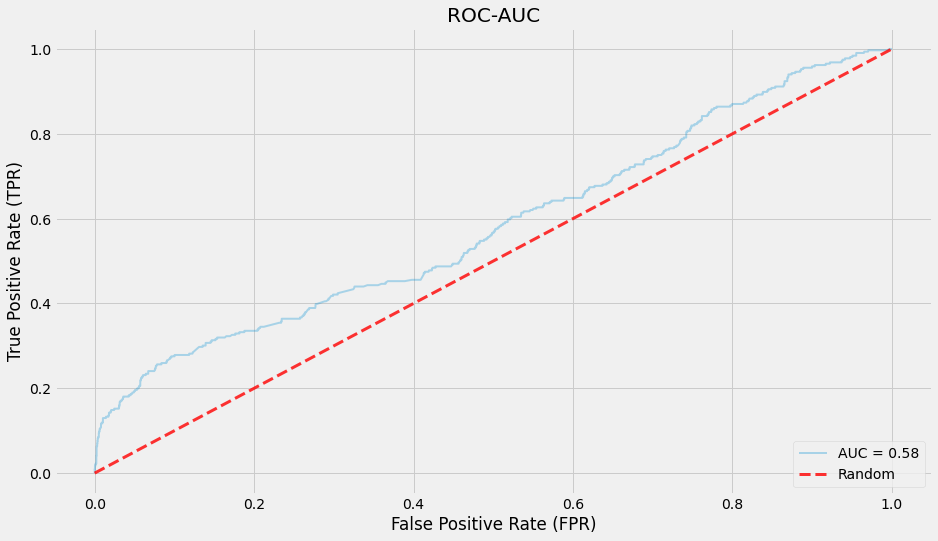

In [55]:
fpr , tpr , threshold = calculate_roc_auc(model4,X_test,y_test)
plot_roc_auc(fpr,tpr)

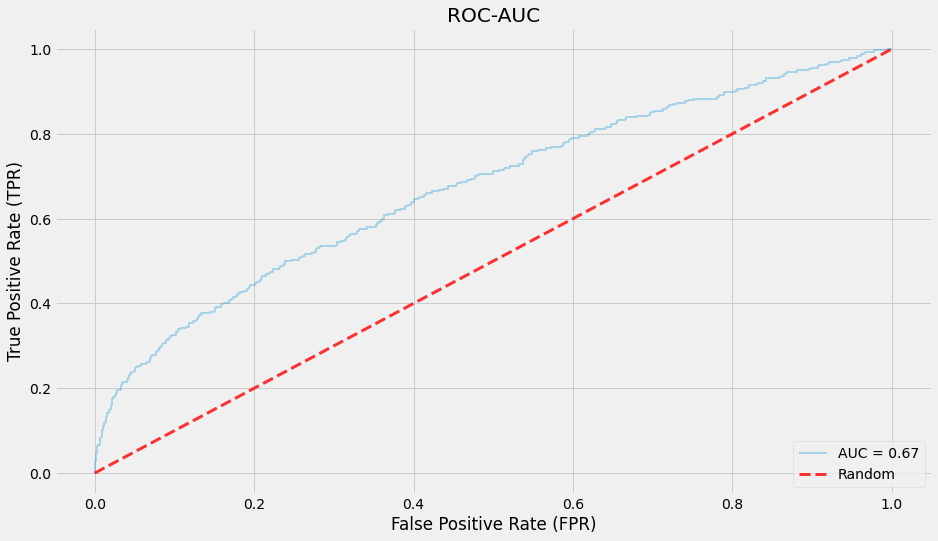

In [56]:
fpr , tpr , threshold = calculate_roc_auc(model5,X_test,y_test)
plot_roc_auc(fpr,tpr)

## 1. Performing Cross validation

In [57]:
from sklearn.model_selection import StratifiedKFold

In [58]:
fprs ,tprs  = [] , []
cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
for (train, test), i in zip(cv.split(X, y), range(5)):
    model4.fit(X.iloc[train], y.iloc[train])
    fpr, tpr, auc_score = calculate_roc_auc(model5, X.iloc[test] , y.iloc[test])
    fprs.append(fpr)
    tprs.append(tpr)

In [59]:
def plot_roc_curve(fprs, tprs):
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(18,10))

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3,
        label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))

 # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label="Random", alpha=.8)

 # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
       label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
       lw=4, alpha=.8)

 # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
      label=r"$\pm$ 1 std. dev.")

 # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

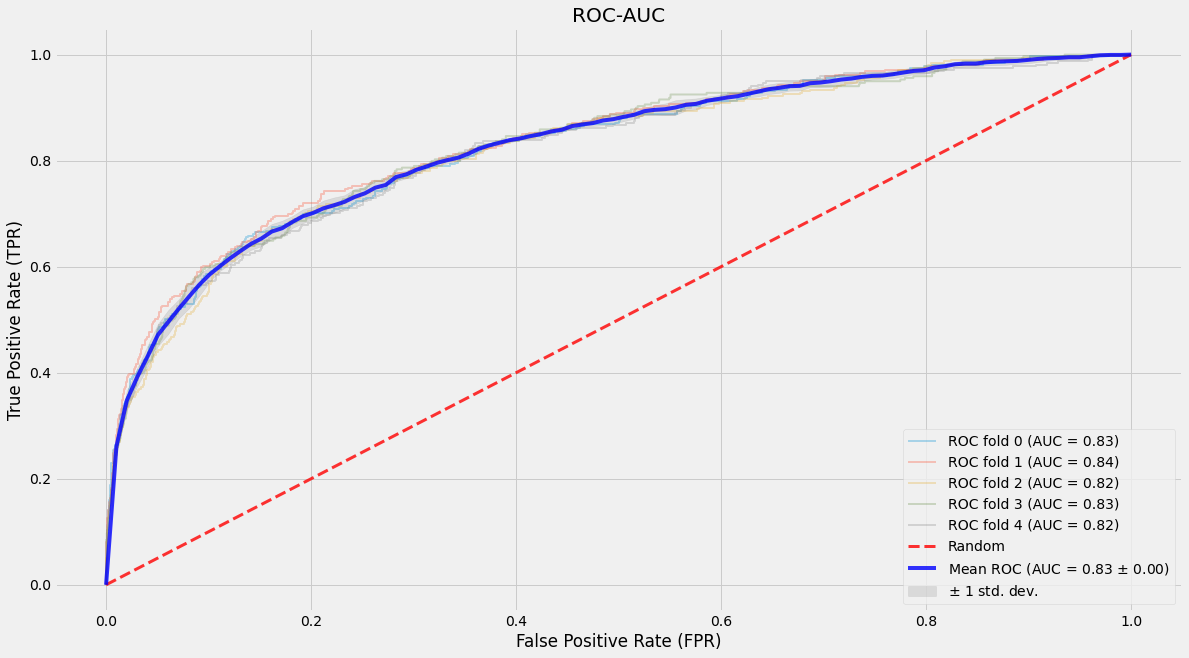

In [60]:
plt.style.use("fivethirtyeight")
plot_roc_curve(fprs, tprs)
plt.show()

The closer the line is to 1 the better the model is , hence we have got our best model here. We are also getting better 0.83 AUC

## 2. Model Evaluation

## PDP plots

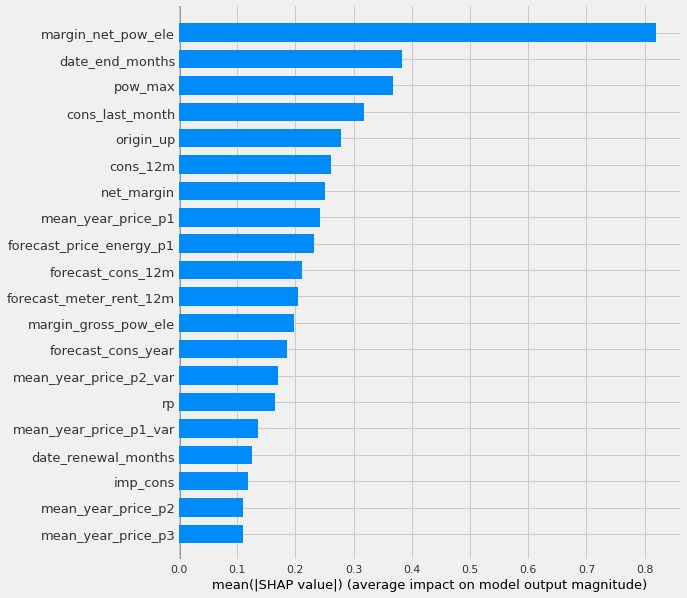

In [61]:
explainer = shap.TreeExplainer(model5)
shap_values = explainer.shap_values(X_test)

# Feature importance for class 1 - churn
shap.summary_plot(shap_values, X_test, plot_type='bar')

We see that margin_net_pow ele is main driver in churning of customers followed by date_end_months, pow_max.

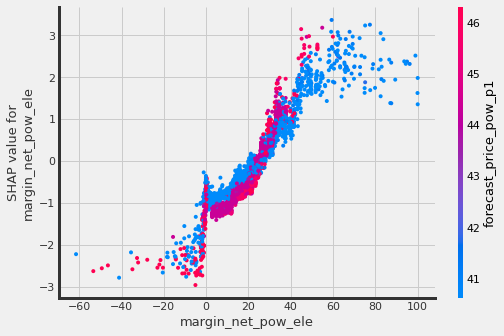

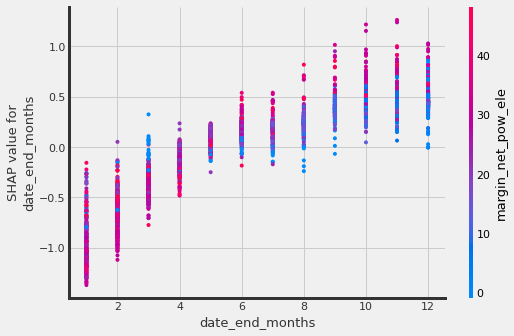

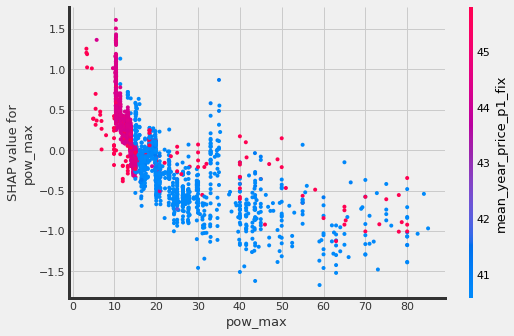

In [62]:

shap.dependence_plot("margin_net_pow_ele", shap_values, X_test)#, interaction_index="origin_lxi")

shap.dependence_plot("date_end_months", shap_values, X_test)

shap.dependence_plot("pow_max", shap_values, X_test)

Now we have seen our most important features that contribute to the model, and therefore churn of our customers. Now building a final model with following variables:
- margin_net_pow_ele - net margin on power suscribption
-  pow_max - max power subscribed.

# Final Analysis


In [86]:
data_subset = data[["margin_net_pow_ele","churn"]]
data_subset1 = data_subset[data_subset['churn']==1]
data_subset2 = data_subset[data_subset['churn']==0] 
data_subset2 = data_subset2.sample(1594)
f_data = pd.concat([data_subset1,data_subset2])
f_data=f_data.sample(frac = 1) 
X = np.array(f_data['margin_net_pow_ele']).reshape(-1,1)
y = f_data['churn']
modelf = xgbr.fit(X,y)
discount = np.arange(0.05,0.3,0.05)
for i in discount:
  print("--------------------------------------------------------")
  f_data["margin_net_pow_ele"] = f_data["margin_net_pow_ele"] - (f_data["margin_net_pow_ele"] *i)
  X_predict = np.array(f_data["margin_net_pow_ele"]).reshape(-1,1)
  churn = modelf.predict(X_predict)
  print(pd.Series(churn).value_counts(normalize = True))
  print("if Discount provided {:.2f} and revenue will be {:.2f}".format(i,f_data['margin_net_pow_ele'].sum()))

--------------------------------------------------------
0    0.549875
1    0.450125
dtype: float64
if Discount provided 0.05 and revenue will be 70820.53
--------------------------------------------------------
0    0.614178
1    0.385822
dtype: float64
if Discount provided 0.10 and revenue will be 63738.47
--------------------------------------------------------
0    0.607905
1    0.392095
dtype: float64
if Discount provided 0.15 and revenue will be 54177.70
--------------------------------------------------------
0    0.607905
1    0.392095
dtype: float64
if Discount provided 0.20 and revenue will be 43342.16
--------------------------------------------------------
0    0.69542
1    0.30458
dtype: float64
if Discount provided 0.25 and revenue will be 32506.62


We can see that we are getting best results when we will provide discount of 0.25, only 24 % of people are churning, but it the revenue then has gone below 35000.
So it will be better to keep the discount of 0.20 , where we have only 28% chances of customer churn and our revenue